# 实验五 循环神经网络实验

# 基本信息
1. 实验名称：实验5 循环神经网络实验
2. 姓名：
3. 学号：
4. 日期：2023年01月08日

# 数据处理


## 高速公路车流量数据

> 介绍
- PeMS是美国加利福尼亚州高速公路的实时车流量数据。（每5分钟采集一次）
- 数据由铺设在道路上的检测线圈采集。
- 本实验中包含一个地区的数据，储存在traffic.npz文件中。
- 原始数据使用numpy二进制文件存储，可以使用numpy.load函数读取。
- 数据中的三个特征维度：车流量、拥挤程度和车速

In [10]:
# 简单尝试 再进行封装
import numpy as np
import pandas as pd
import torch.utils.data as data
import warnings
import math
import torch
from torch import nn
from datasets import *

warnings.filterwarnings("ignore")

In [4]:
raw_data = np.load('../Datasets/traffic-flow/traffic.npz')['data']
print(raw_data.shape)
print(raw_data)

(17856, 170, 3)
[[[1.330e+02 6.030e-02 6.580e+01]
  [2.100e+02 5.890e-02 6.960e+01]
  [1.240e+02 3.580e-02 6.580e+01]
  ...
  [7.400e+01 2.131e-01 6.530e+01]
  [9.400e+01 2.260e-02 6.800e+01]
  [6.000e+00 3.100e-03 6.500e+01]]

 [[1.140e+02 5.320e-02 6.690e+01]
  [1.850e+02 5.500e-02 6.850e+01]
  [1.190e+02 3.390e-02 6.500e+01]
  ...
  [7.300e+01 1.469e-01 3.720e+01]
  [8.400e+01 1.890e-02 6.870e+01]
  [4.000e+00 1.800e-03 6.500e+01]]

 [[1.400e+02 6.220e-02 6.680e+01]
  [1.710e+02 4.660e-02 6.990e+01]
  [1.070e+02 3.360e-02 6.380e+01]
  ...
  [7.000e+01 5.860e-02 3.400e+01]
  [8.200e+01 2.200e-02 6.700e+01]
  [4.000e+00 2.100e-03 6.490e+01]]

 ...

 [[1.200e+02 5.810e-02 6.330e+01]
  [1.760e+02 5.290e-02 6.680e+01]
  [1.190e+02 5.180e-02 5.610e+01]
  ...
  [4.700e+01 1.551e-01 3.220e+01]
  [9.100e+01 2.290e-02 6.640e+01]
  [3.000e+00 1.400e-03 6.530e+01]]

 [[1.020e+02 5.790e-02 6.140e+01]
  [1.650e+02 4.920e-02 6.720e+01]
  [1.330e+02 5.070e-02 5.890e+01]
  ...
  [9.700e+01 1.265e-01

In [5]:
print(raw_data.shape)

(17856, 170, 3)


print(raw_data.shape)
可以看到数据包含3个维度。

- 第一个维度代表数据的总条数。也就是说，原始长序列总长为16992.
- 第二个维度代表传感器的数量。
- 第三个维度代表每个传感器收集到的不同种类数据，分别为车流量、拥挤程度和车速。在实际实验中，可以任意选取一个特征进行预测。

综上所述，本数据集包含170个传感器，每个传感器都包含长度为17856的连续采样值序列。在构造训练集时，可首先将每个传感器的长序列划分为训练/验证/测试序列，再使用滑动窗口。本数据的时间轴**已经被规整化且无任何缺失值，因此仅需使用固定长度的滑动窗口**。

In [6]:
target = 0       # 选择第一维数据进行预测
window_size = 12
sensor_num = 5      # 选择5号感器

train_x = []
train_y = []
len_train = int(raw_data.shape[0] * 0.6)
train_seqs = raw_data[:len_train]
for i in range(train_seqs.shape[0] - window_size):
    train_x.append(train_seqs[i:i+window_size, sensor_num, :].squeeze())
    train_y.append(train_seqs[i+window_size, sensor_num, target].squeeze())

train_x = torch.Tensor(train_x)
train_y = torch.Tensor(train_y)
train_x.shape

torch.Size([10701, 12, 3])

In [8]:
'''
在原有的datasets.py文件的基础上，进行数据封装。在jupyter中给出可运行的代码，但是在后续实验中，还是调用datasets.py 文件中的内容
'''
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]


class TrafficDataset:
    def __init__(self, file_path="../Datasets/traffic-flow/traffic.npz", sensor=8, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load(file_path)['data']
        self.sensor = sensor
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
    # 增加鲁棒性
        assert train_por + test_por < 1

        #  补全构造过程
        len_train=int(self.data.shape[0]*train_por)
        train_seqs=self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor, self.target].squeeze())

        len_val = int(self.data.shape[0] * (train_por + test_por))
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0]-window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor, self.target].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(val_seqs.shape[0]-window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor,:].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor, self.target].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

# RNN
## 手动实现RNN

观察RNN的计算公式：
$$h_t=\sigma (W_h x_t+U_h h_{t-1} + b_h),\ y_t=\sigma (W_y h_t+b_y)$$
其中$x_t$是t步的输入；$h_t$是t步的隐藏状态，需要我们初始化，并在每步间循环更新；$W_h,W_y,b_h,b_y$则是可学习参数；$\sigma$是激活函数，计算新的隐藏状态时一般使用Tanh，计算状态时需要考虑我们期望的输出的范围。例如，希望输出为非负，则使用ReLU。

为了方便管理，我们将所有参数和计算过程集中在一个类中。

### 类的定义

In [11]:


class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size

        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))

        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()

        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) +
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [12]:
# 简单测试

device = 'cuda:0'
batch_size = 64
seq_len = 12
input_size = 2
hidden_size = 32
output_size = 1

x = torch.rand(batch_size, seq_len, input_size).to(device)
rnn = MyRNN(input_size, hidden_size, output_size).to(device)
hidden, y = rnn(x)
print(hidden.shape, y.shape)

torch.Size([64, 12, 1]) torch.Size([64, 32])


### 使用RNN进行实验

In [16]:

TrafficData = TrafficDataset()
data_df = TrafficData.data
data_df

array([[[1.15954664e-01, 5.25719268e-05, 5.73670445e-02],
        [1.83086312e-01, 5.13513514e-05, 6.06800349e-02],
        [1.08108108e-01, 3.12118570e-05, 5.73670445e-02],
        ...,
        [6.45161290e-02, 1.85789015e-04, 5.69311247e-02],
        [8.19529207e-02, 1.97035745e-05, 5.92850915e-02],
        [5.23103749e-03, 2.70270270e-06, 5.66695728e-02]],

       [[9.93897123e-02, 4.63818657e-05, 5.83260680e-02],
        [1.61290323e-01, 4.79511770e-05, 5.97210113e-02],
        [1.03748910e-01, 2.95553618e-05, 5.66695728e-02],
        ...,
        [6.36442895e-02, 1.28073235e-04, 3.24324324e-02],
        [7.32345248e-02, 1.64777681e-05, 5.98953793e-02],
        [3.48735833e-03, 1.56931125e-06, 5.66695728e-02]],

       [[1.22057541e-01, 5.42284220e-05, 5.82388840e-02],
        [1.49084568e-01, 4.06277245e-05, 6.09415867e-02],
        [9.32868352e-02, 2.92938099e-05, 5.56233653e-02],
        ...,
        [6.10287707e-02, 5.10897995e-05, 2.96425458e-02],
        [7.14908457e-02, 1.91

In [17]:
train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

In [20]:
# 为了保证模型能够正常训练，模型的输入需要进行归一化。我们已经在数据集的初始化过程中进行了归一化。
# 在测试模型时，需要将数据反归一化以得到正常的测试结果
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)



train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0139, train rmse 113.5323, val loss 0.0046, val rmse 65.128517, time use 2.056s
*** epoch2, train loss 0.0039, train rmse 70.1588, val loss 0.0035, val rmse 55.028989, time use 1.547s
*** epoch3, train loss 0.0030, train rmse 61.3623, val loss 0.0030, val rmse 50.392386, time use 1.428s
*** epoch4, train loss 0.0025, train rmse 56.6396, val loss 0.0028, val rmse 50.676847, time use 1.487s
*** epoch5, train loss 0.0023, train rmse 53.6217, val loss 0.0025, val rmse 45.152200, time use 1.534s
*** epoch6, train loss 0.0022, train rmse 51.9544, val loss 0.0023, val rmse 44.114892, time use 1.595s
*** epoch7, train loss 0.0020, train rmse 50.6615, val loss 0.0023, val rmse 43.661687, time use 1.558s
*** epoch8, train loss 0.0020, train rmse 49.7746, val loss 0.0022, val rmse 41.983169, time use 1.644s
*** epoch9, train loss 0.0019, train rmse 49.2295, val loss 0.0021, val rmse 41.732188, time use 1.618s
*** epoch10, train loss 0.0019, train rmse 48.4254, val loss 0.

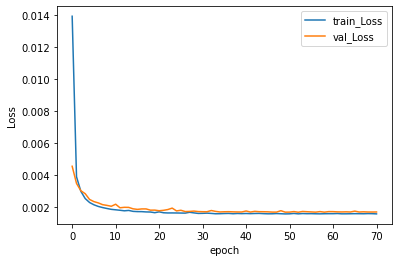

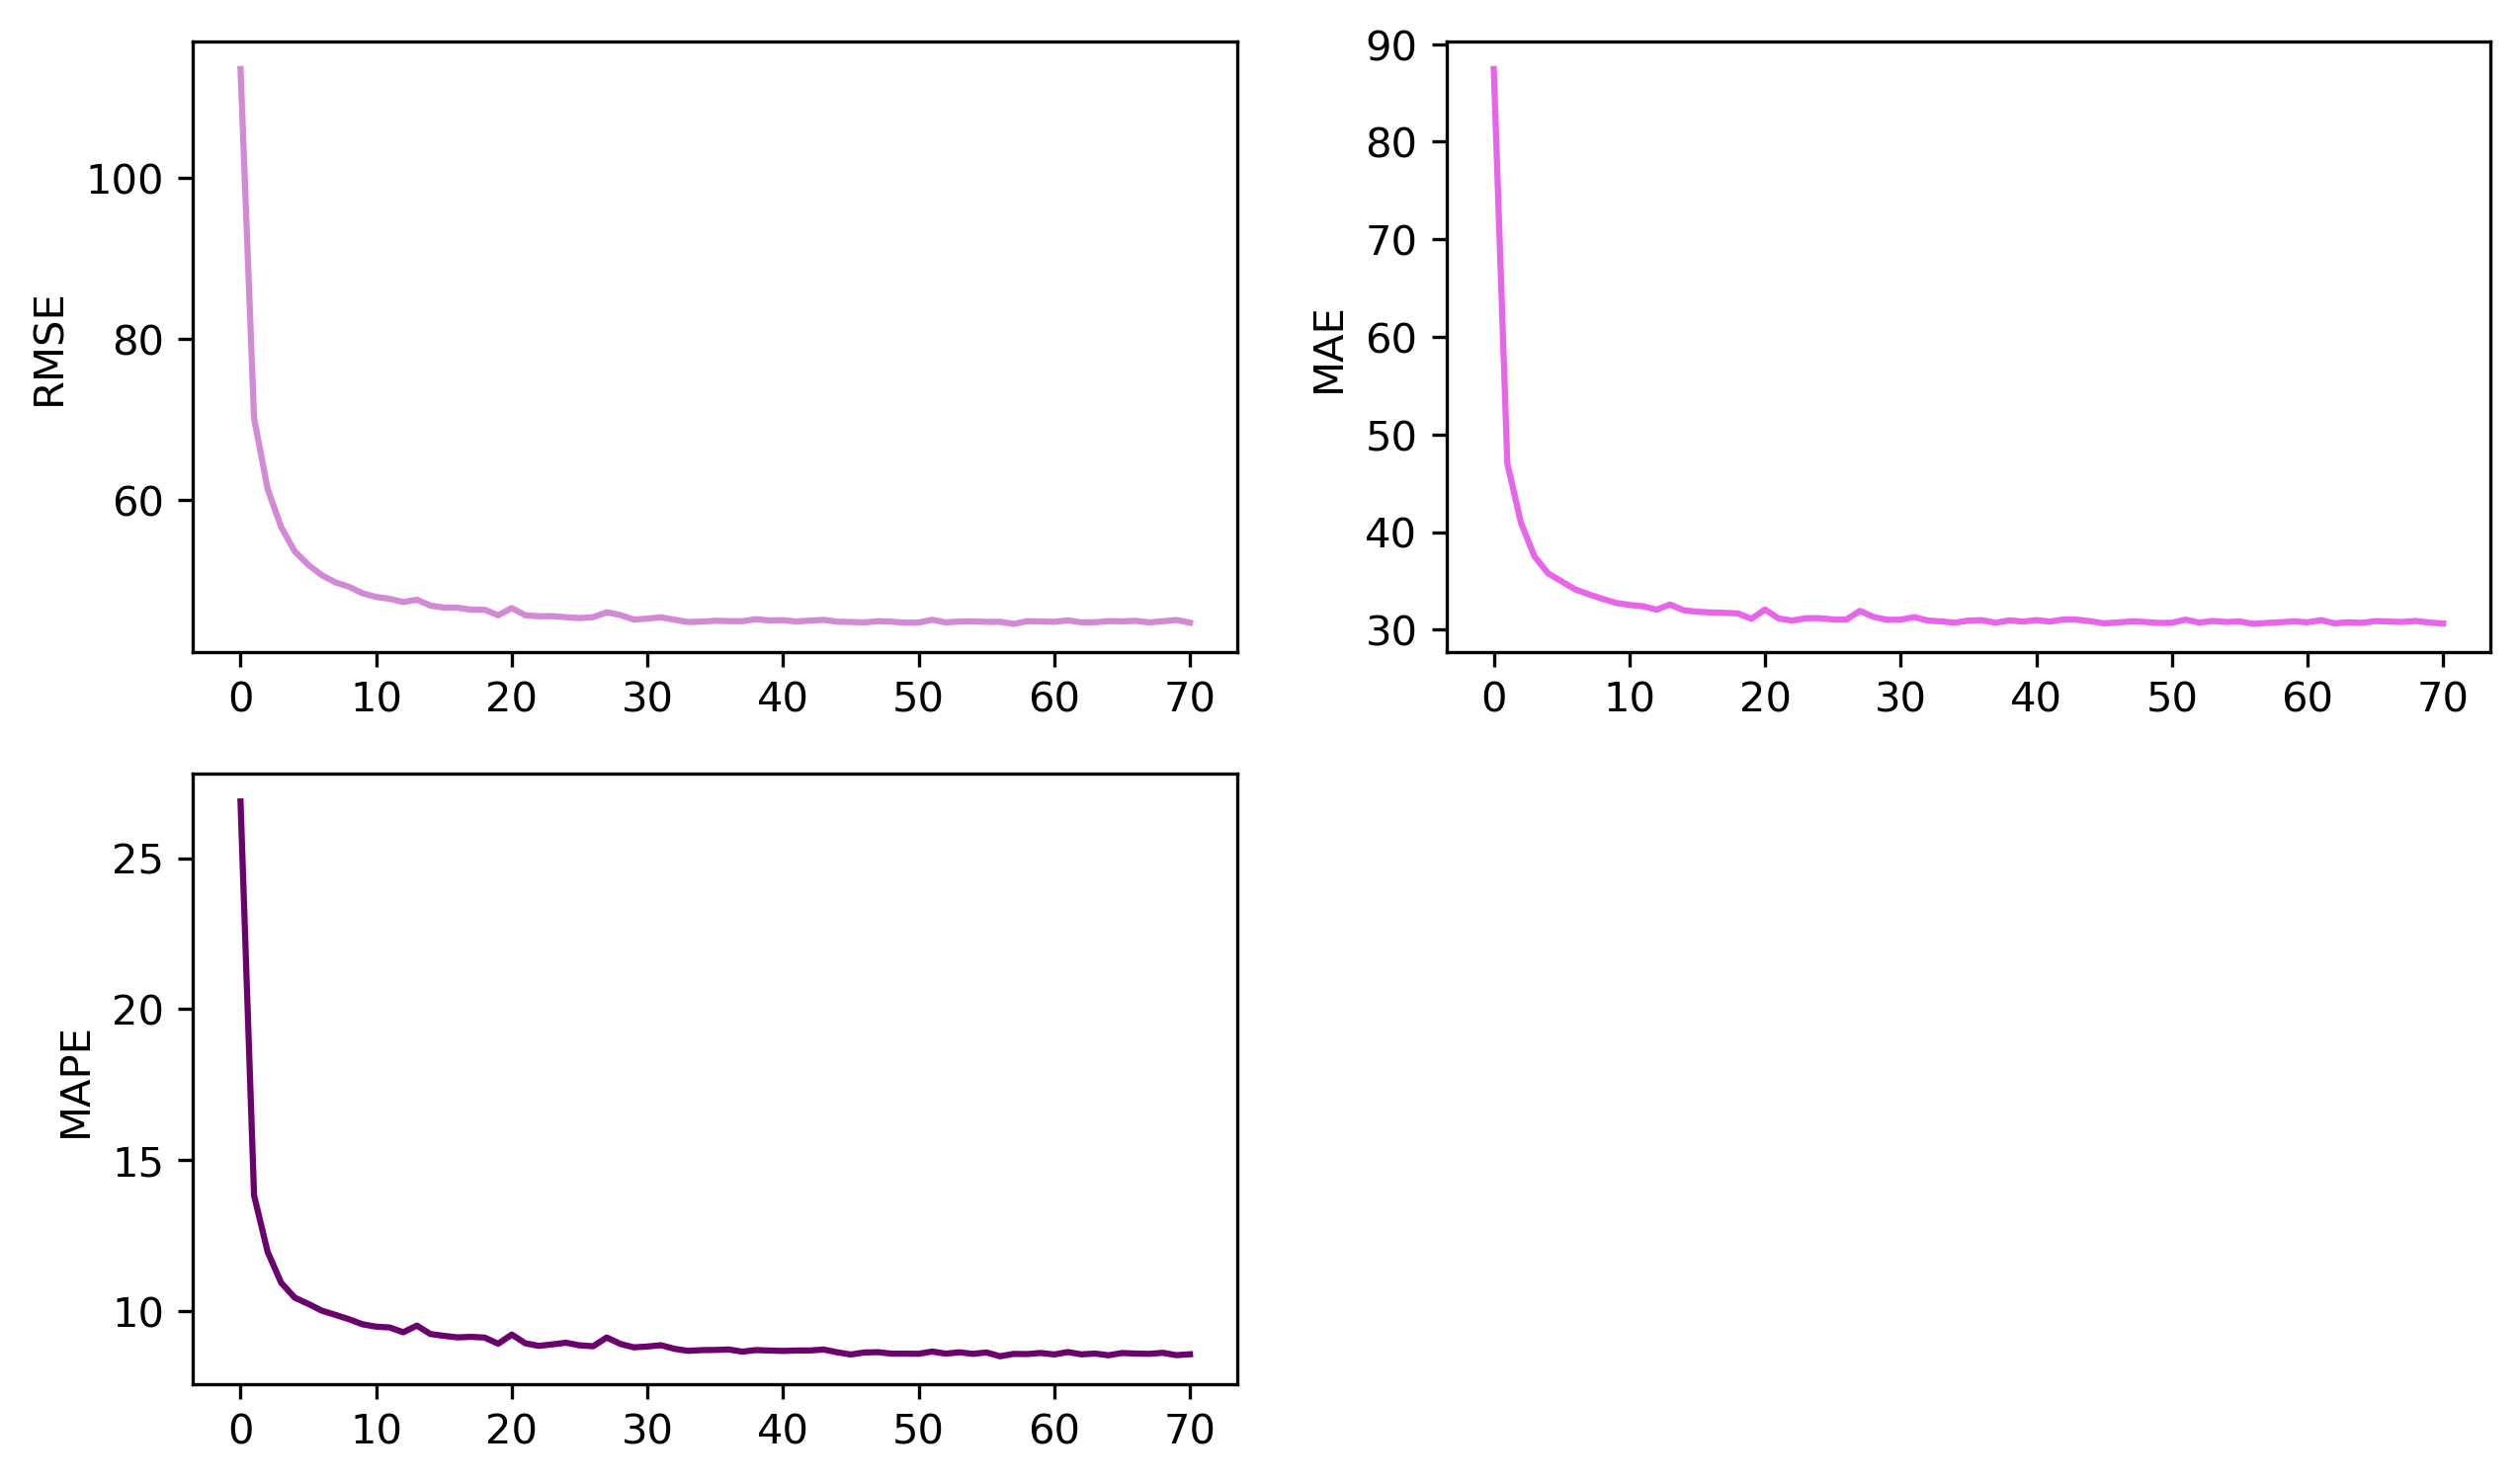

In [21]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## PyTorch接口实现RNN

In [22]:
bi_rnn = nn.RNN(input_size=2, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)

In [23]:
device = 'cuda:0'
batch_size = 32
seq_len = 12
input_size = 2

x = torch.randn(batch_size, seq_len, input_size).to(device)
bi_rnn = bi_rnn.to(device)
output, hidden = bi_rnn(x)
print(output.shape, hidden.shape)

torch.Size([32, 12, 128]) torch.Size([2, 32, 64])


In [24]:
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0235, train rmse 164.2564, val loss 0.0039, val rmse 62.713004, time use 1.034s
*** epoch2, train loss 0.0038, train rmse 69.2038, val loss 0.0035, val rmse 57.435982, time use 0.531s
*** epoch3, train loss 0.0034, train rmse 66.1458, val loss 0.0032, val rmse 55.012434, time use 0.601s
*** epoch4, train loss 0.0031, train rmse 62.6698, val loss 0.0030, val rmse 52.215428, time use 0.562s
*** epoch5, train loss 0.0028, train rmse 59.6162, val loss 0.0028, val rmse 49.563161, time use 0.527s
*** epoch6, train loss 0.0026, train rmse 57.1426, val loss 0.0026, val rmse 47.776815, time use 0.652s
*** epoch7, train loss 0.0024, train rmse 55.4041, val loss 0.0026, val rmse 46.637262, time use 0.579s
*** epoch8, train loss 0.0023, train rmse 54.0587, val loss 0.0025, val rmse 45.974745, time use 1.093s
*** epoch9, train loss 0.0022, train rmse 52.9646, val loss 0.0025, val rmse 44.951427, time use 0.742s
*** epoch10, train loss 0.0022, train rmse 52.0447, val loss 0.

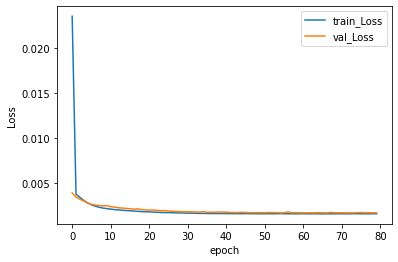

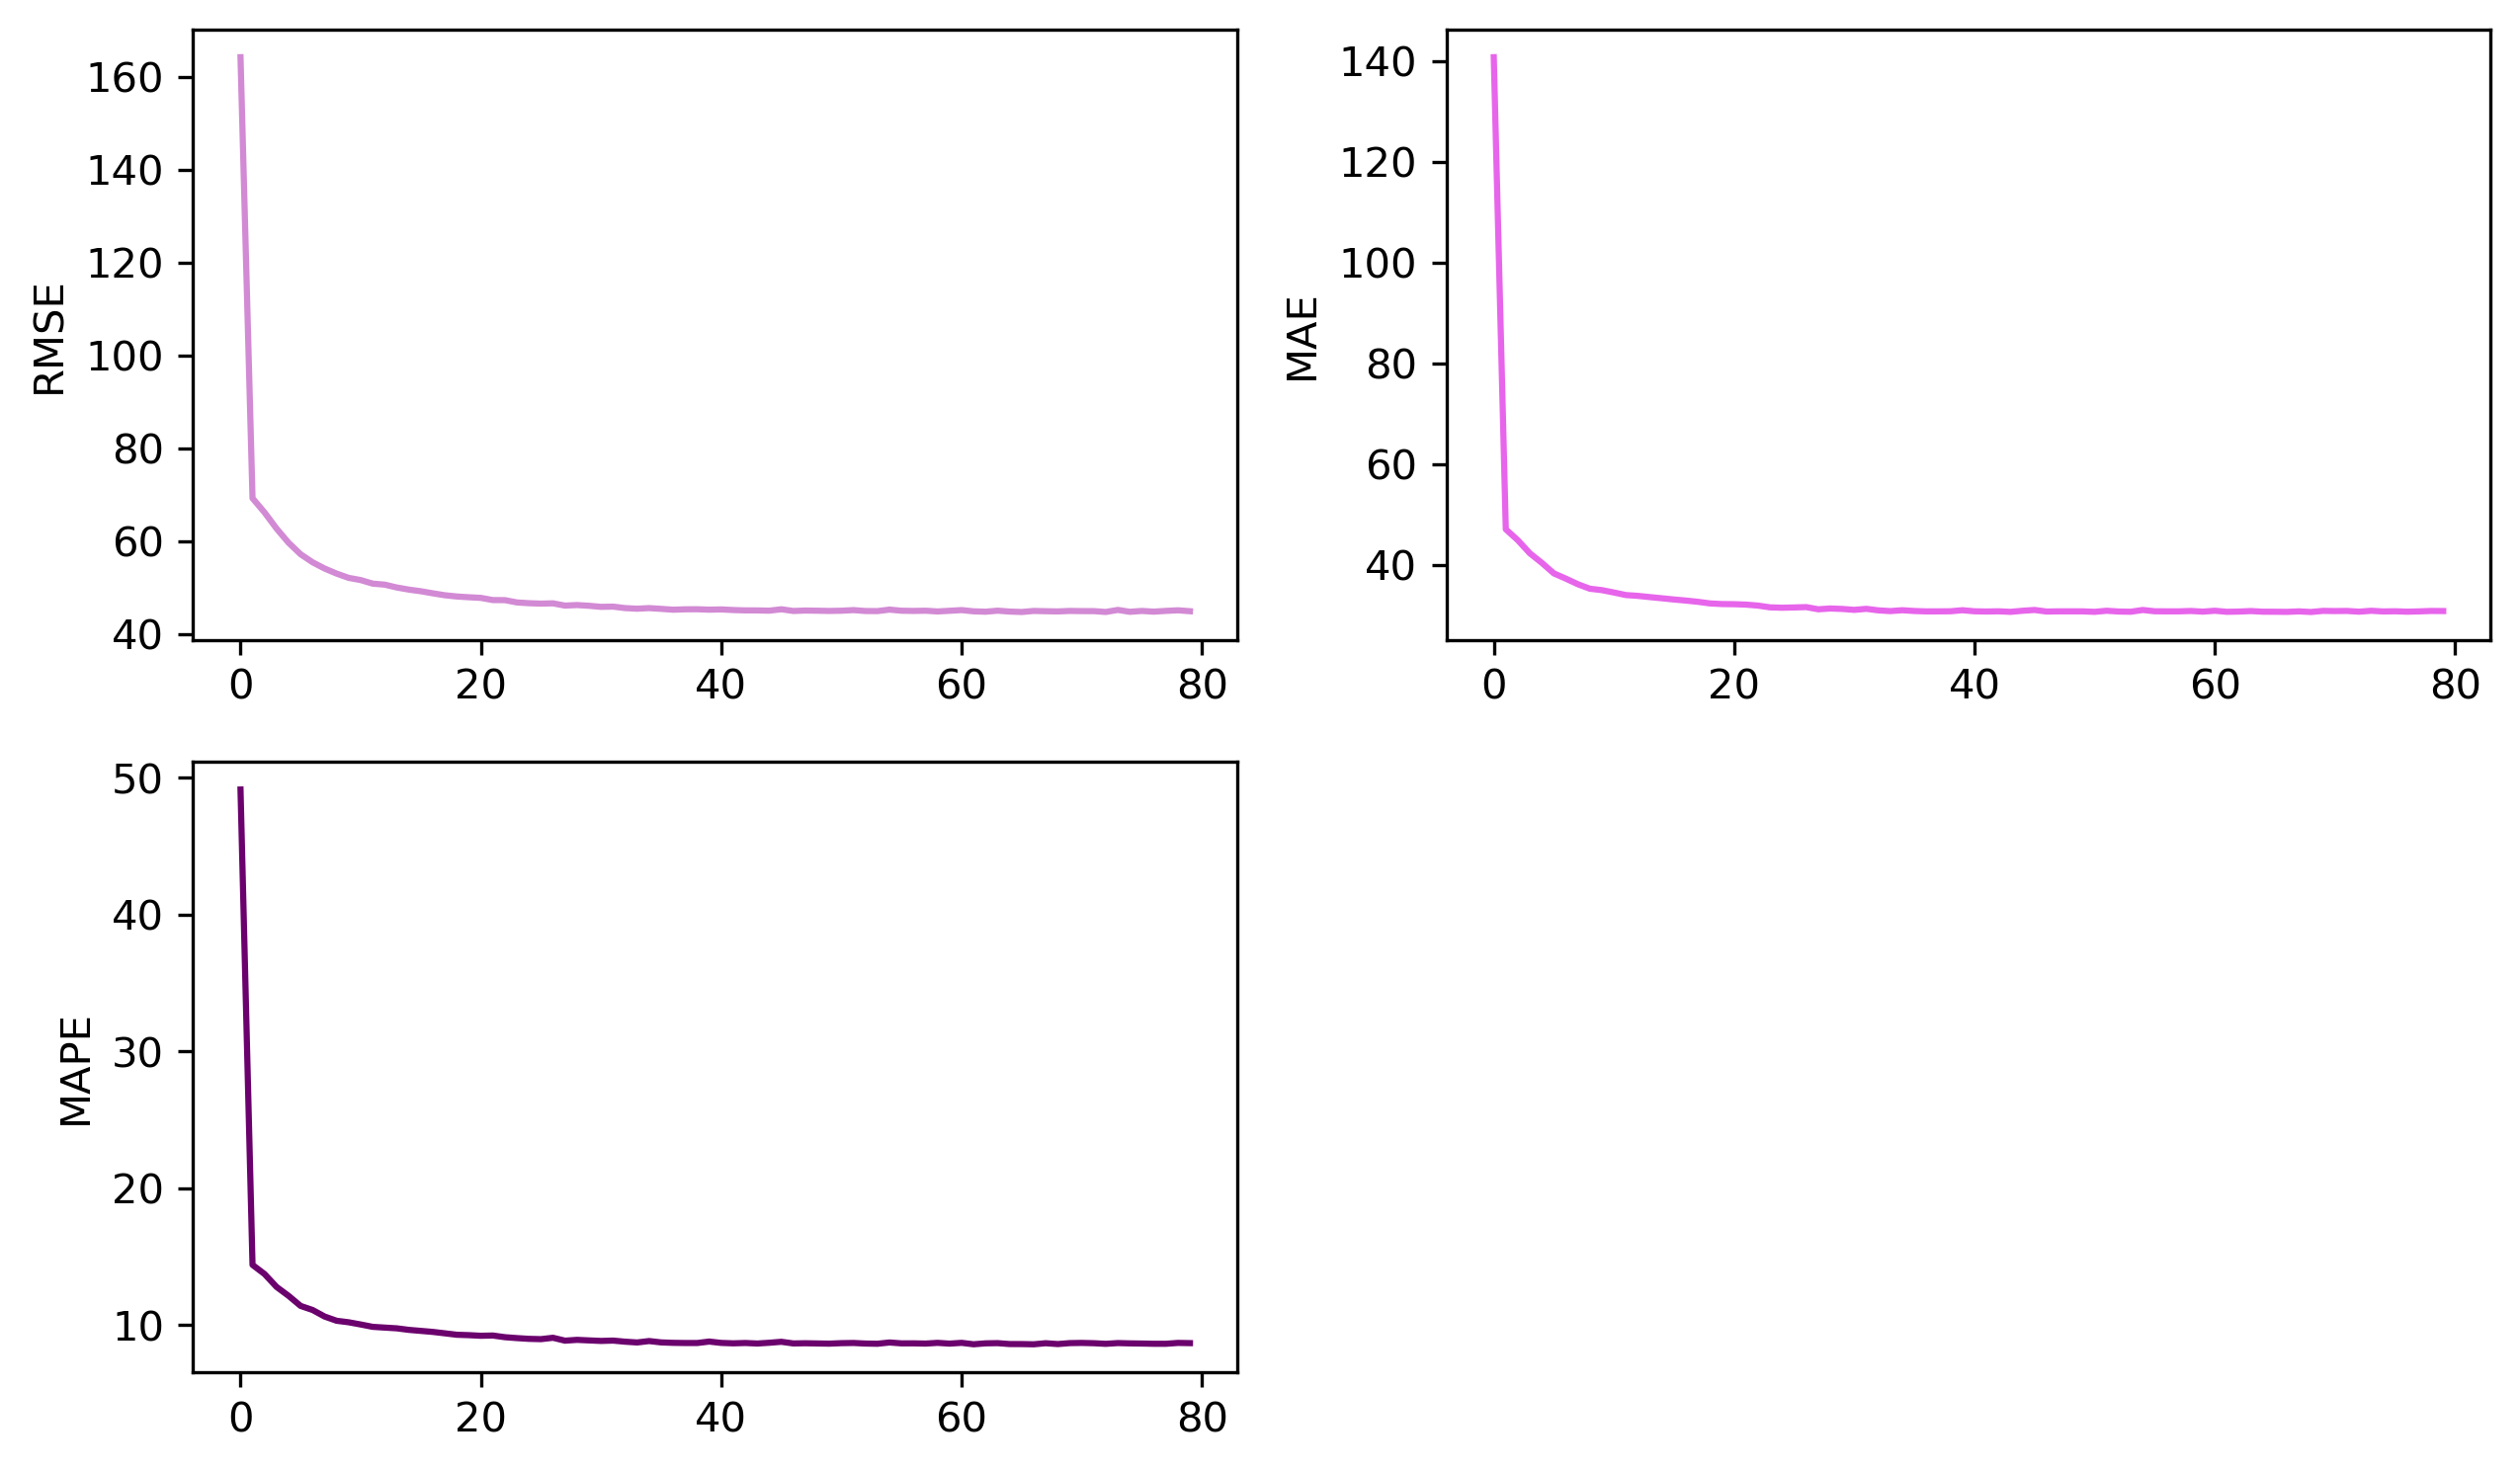

In [25]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

# LSTM
## 手动实现LSTM

In [63]:
# 按照实验课要求，不使用Linear直接进行并行化计算, 而采用分开门合并又分开的方法

class My_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

        self.w_f = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_f = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.w_i = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_i = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.w_o = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_o = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.w_c = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_c = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
        #         合并参数

        f = torch.cat([self.w_f, self.u_f.data], dim=0)
        i = torch.cat([self.w_i.data, self.u_i], dim=0)
        o = torch.cat([self.w_o, self.u_o], dim=0)
        c = torch.cat([self.w_c, self.u_c], dim=0)

        self.b = nn.Parameter(torch.cat([self.b_f, self.b_i, self.b_o, self.b_c]))
        self.gate = nn.Parameter(torch.cat([f, i, o, c], dim=-1))

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 需要初始化隐藏状态和细胞状态
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []

        for i in range(seq_len):
            input = torch.cat([x[:, i, :], h], dim=-1)
            # 参数拆分

            forget_gate, input_gate, output_gate, candidate_cell = (torch.matmul(input, self.gate) + self.b).chunk(4, -1)

            forget_gate, input_gate, output_gate = (self.sigmoid(g) for g in (forget_gate, input_gate, output_gate))

            # 三个门均通过hadamard积作用在每一个维度上。
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [65]:
device = 'cuda:0'
batch_size = 64
seq_len = 12
input_size = 2
hidden_size = 32
output_size = 1

x = torch.rand(batch_size, seq_len, input_size).to(device)
lstm = My_LSTM(input_size, hidden_size, output_size).to(device)

hidden, y = lstm(x)
print(hidden.shape, y[0].shape, y[1].shape)

torch.Size([64, 12, 1]) torch.Size([64, 32]) torch.Size([64, 32])


In [66]:
from utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_lstm.parameters(), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.1337, train rmse 374.6763, val loss 0.0036, val rmse 59.648751, time use 3.736s
*** epoch2, train loss 0.0033, train rmse 64.7376, val loss 0.0031, val rmse 53.250303, time use 3.082s
*** epoch3, train loss 0.0030, train rmse 61.2242, val loss 0.0029, val rmse 51.353985, time use 3.040s
*** epoch4, train loss 0.0028, train rmse 59.8881, val loss 0.0028, val rmse 50.503174, time use 2.998s
*** epoch5, train loss 0.0027, train rmse 59.0451, val loss 0.0027, val rmse 49.839640, time use 3.155s
*** epoch6, train loss 0.0027, train rmse 58.2362, val loss 0.0026, val rmse 49.348244, time use 3.142s
*** epoch7, train loss 0.0026, train rmse 57.6398, val loss 0.0026, val rmse 48.761015, time use 3.807s
*** epoch8, train loss 0.0025, train rmse 56.8419, val loss 0.0025, val rmse 47.902039, time use 3.676s
*** epoch9, train loss 0.0025, train rmse 55.9901, val loss 0.0025, val rmse 47.437818, time use 3.185s
*** epoch10, train loss 0.0024, train rmse 55.0919, val loss 0.

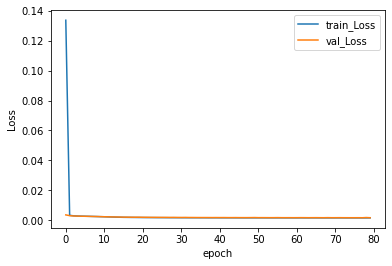

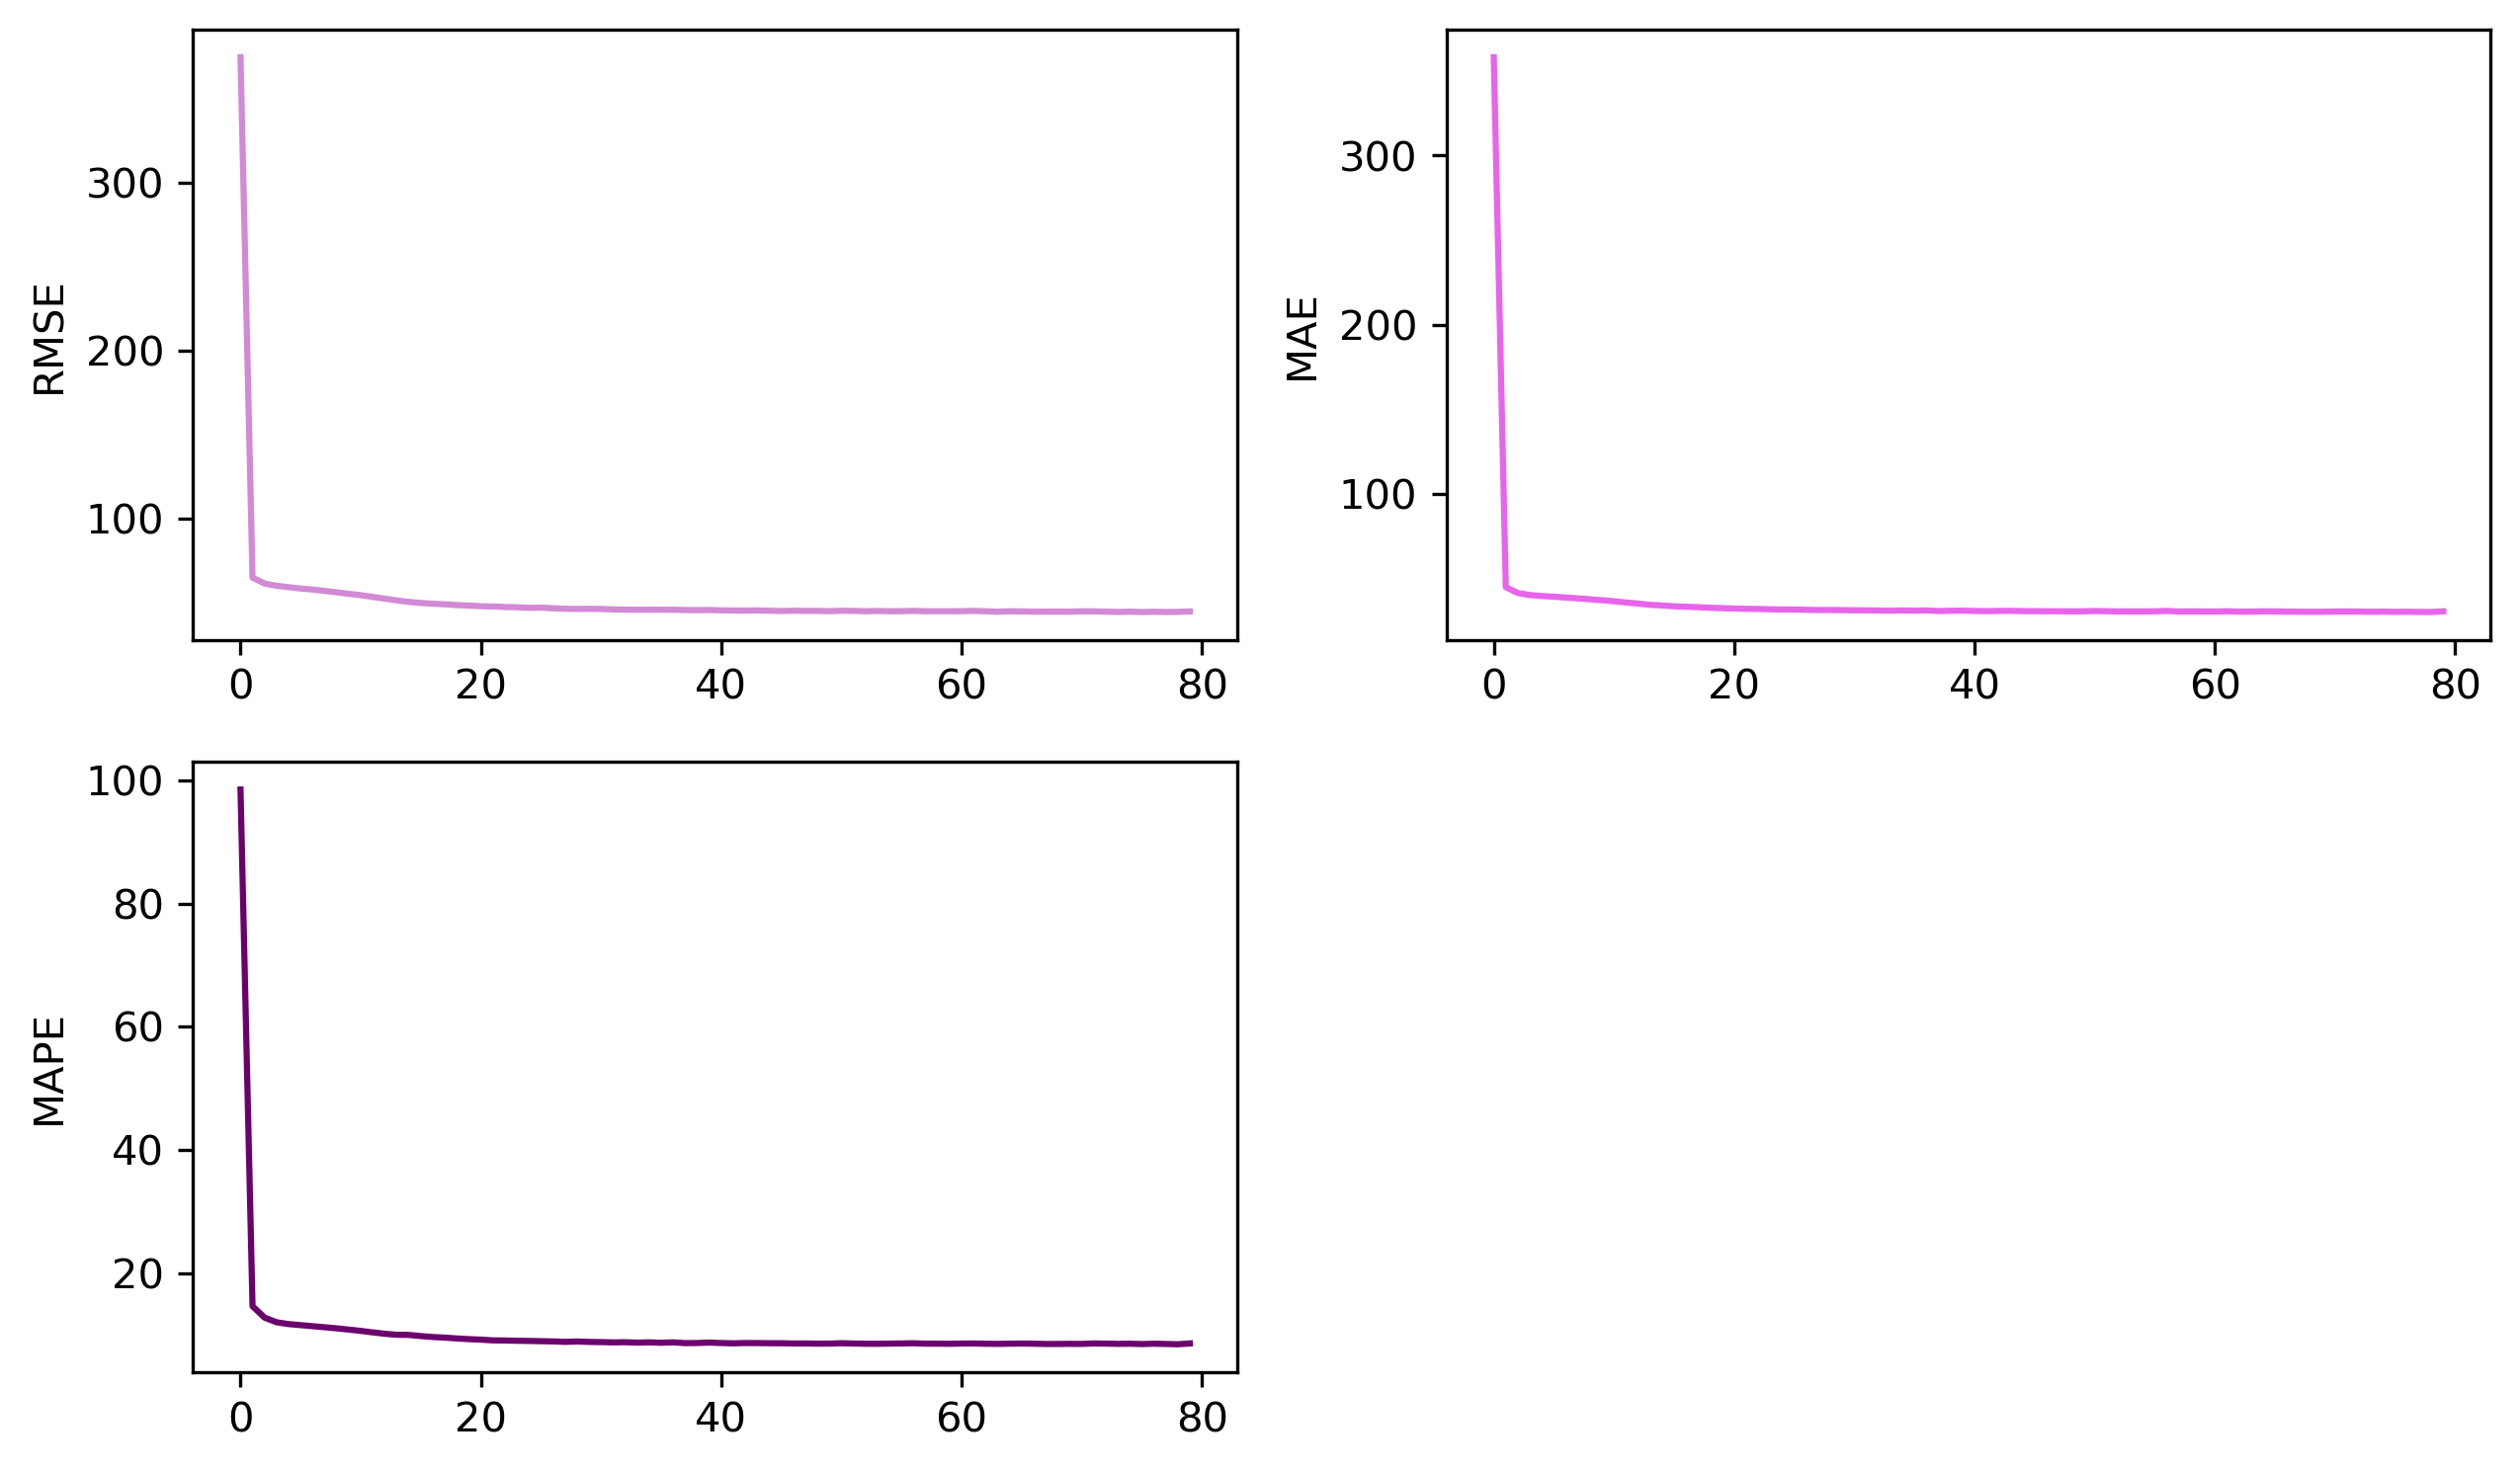

In [67]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## PyTorch接口实现LSTM

In [72]:
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader, loss_func, TrafficData.denormalize, optimizer, epochs, early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0735, train rmse 296.6803, val loss 0.0201, val rmse 146.780825, time use 0.982s
*** epoch2, train loss 0.0180, train rmse 153.4588, val loss 0.0131, val rmse 118.064855, time use 0.684s
*** epoch3, train loss 0.0086, train rmse 104.3242, val loss 0.0046, val rmse 69.676464, time use 0.652s
*** epoch4, train loss 0.0039, train rmse 71.1341, val loss 0.0039, val rmse 62.798728, time use 0.687s
*** epoch5, train loss 0.0038, train rmse 69.4927, val loss 0.0038, val rmse 61.406502, time use 0.654s
*** epoch6, train loss 0.0036, train rmse 68.4504, val loss 0.0036, val rmse 60.183191, time use 0.713s
*** epoch7, train loss 0.0035, train rmse 67.1833, val loss 0.0035, val rmse 58.733480, time use 0.790s
*** epoch8, train loss 0.0034, train rmse 66.0942, val loss 0.0034, val rmse 58.025258, time use 0.756s
*** epoch9, train loss 0.0033, train rmse 65.0105, val loss 0.0033, val rmse 57.153469, time use 0.733s
*** epoch10, train loss 0.0032, train rmse 63.9569, val los

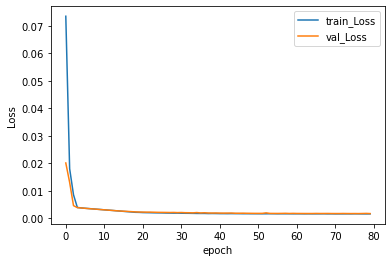

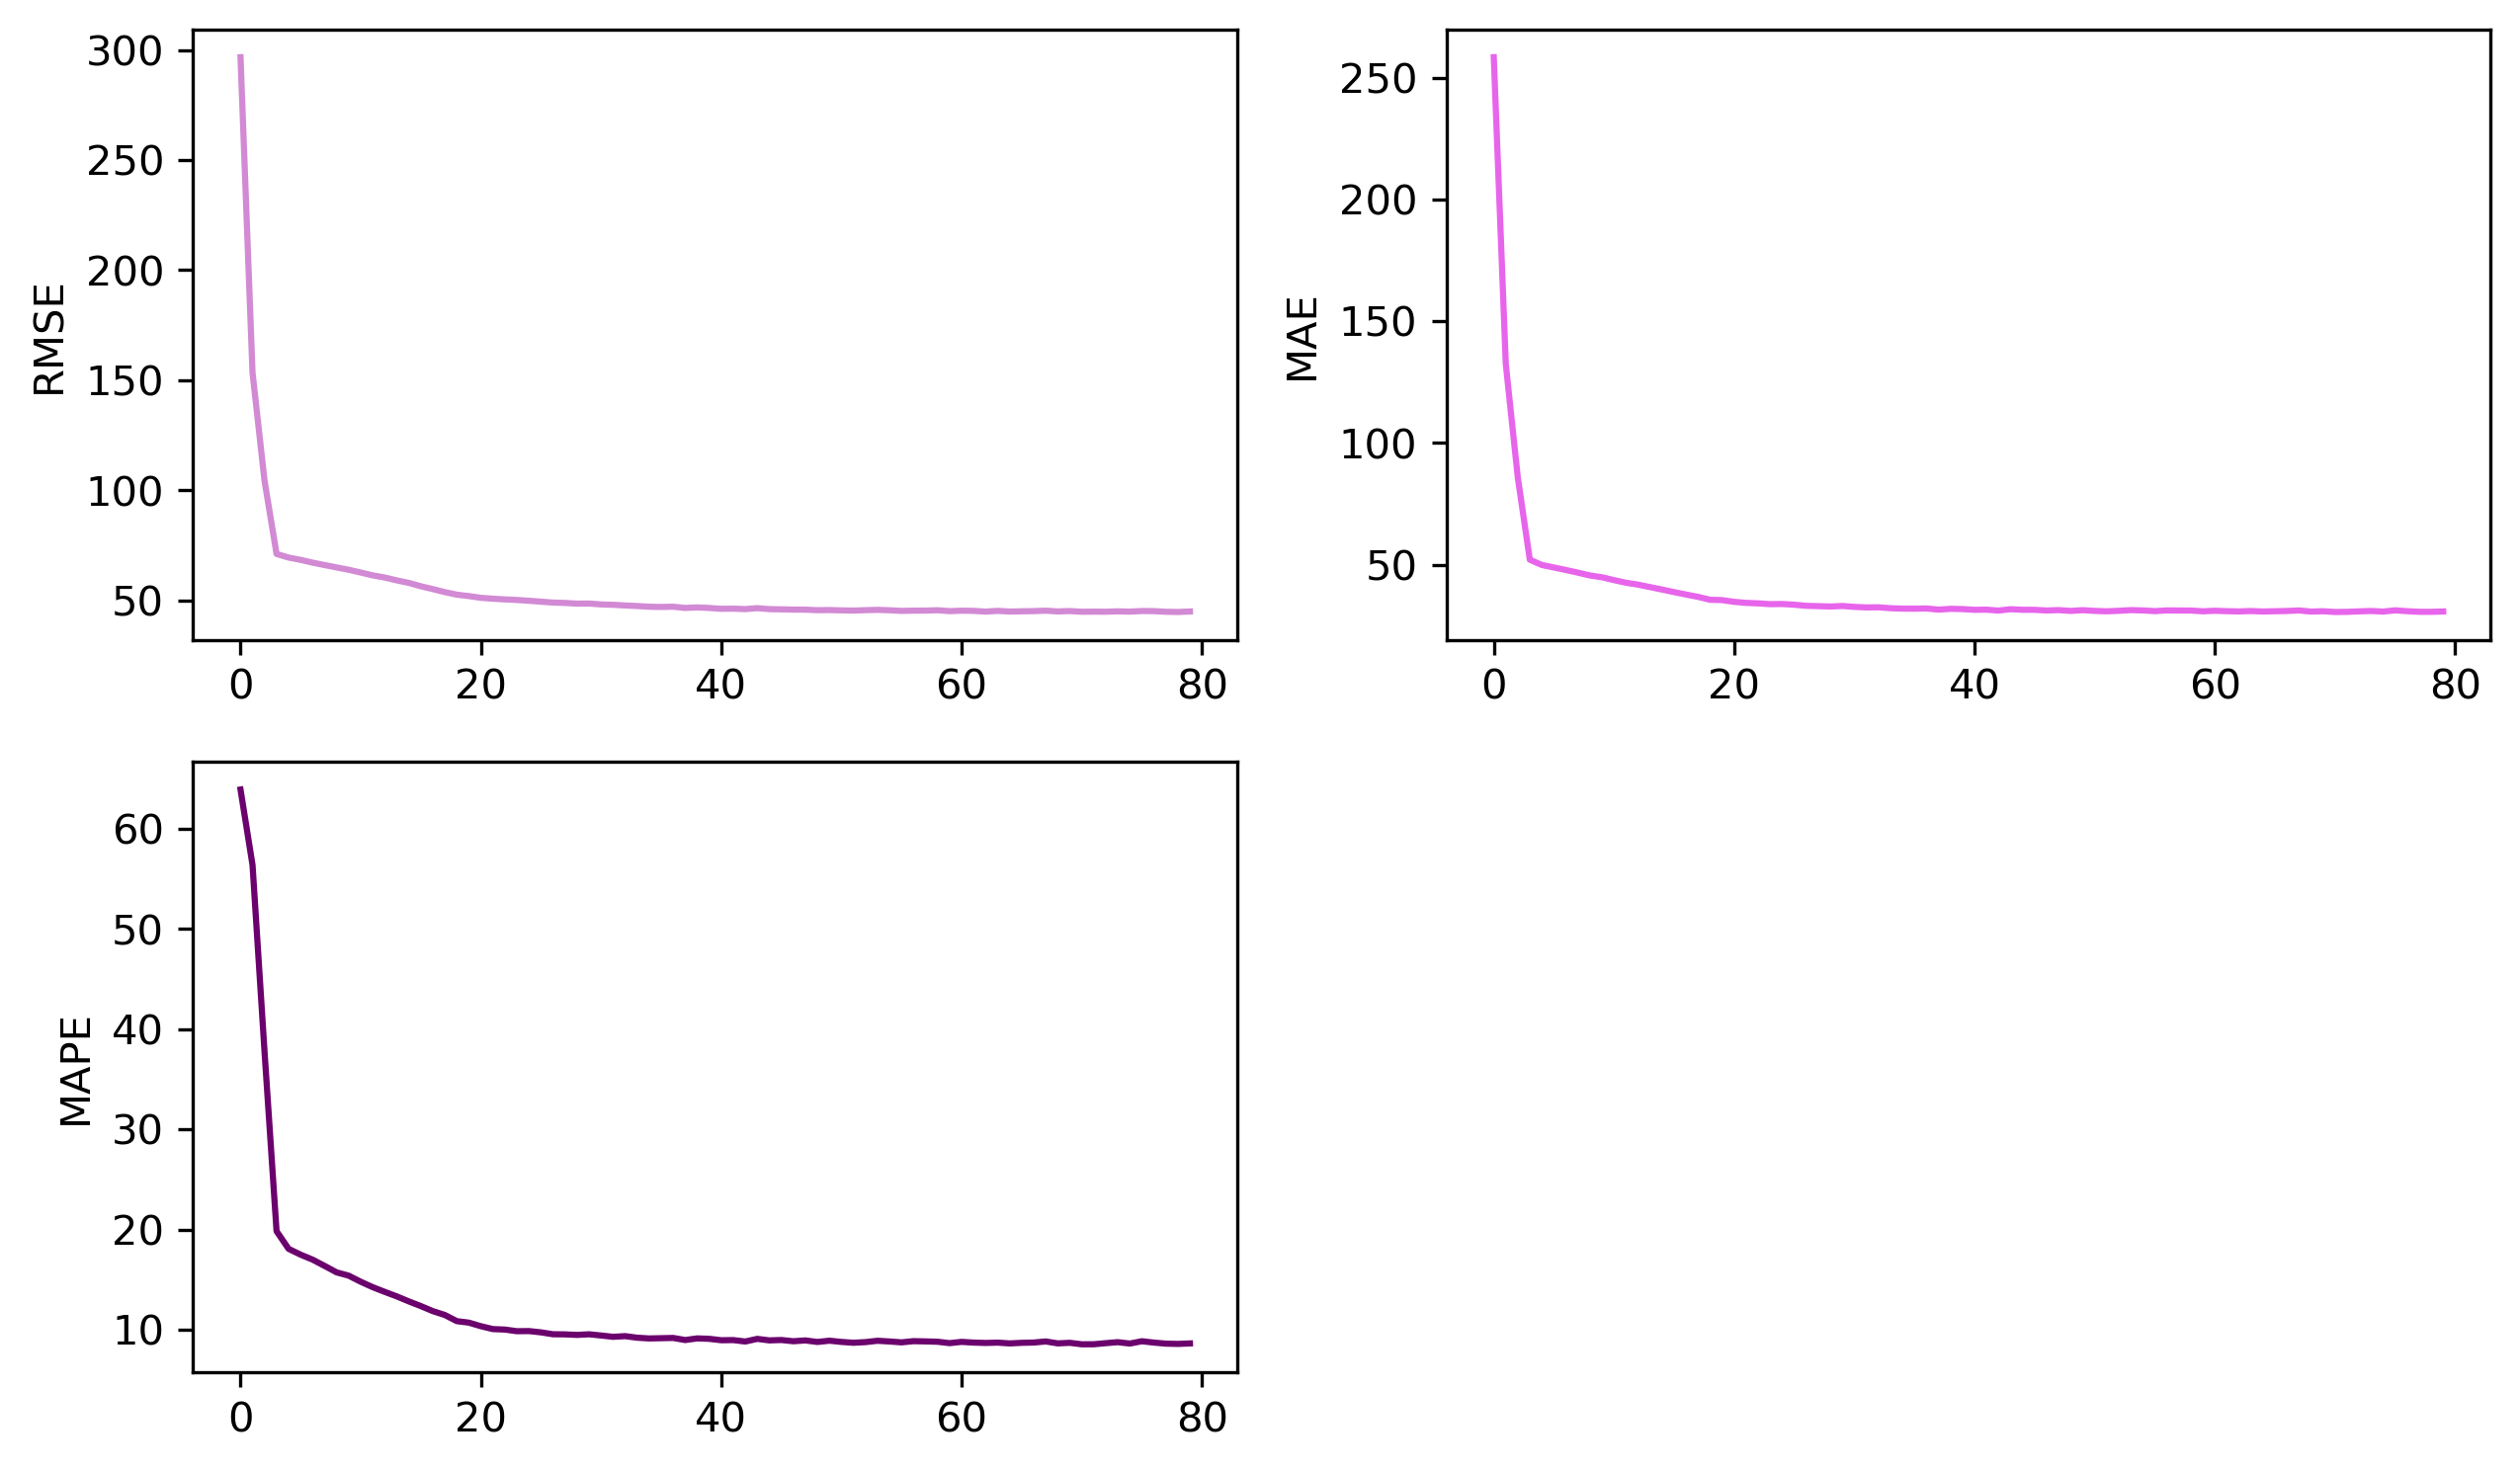

In [74]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

# GRU
## 手动实现GRU

In [68]:
# 并行化计算要求同LSTM

class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.w_z = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_z = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.zeros(hidden_size))

        self.w_r = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_r = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.zeros(hidden_size))

        # self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state 无法加入并行计算中
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

        z = torch.cat([self.w_z, self.u_z], dim=0)
        r = torch.cat([self.w_r, self.u_r], dim=0)

        self.b = nn.Parameter(torch.cat([self.b_z, self.b_r]))
        self.gate = nn.Parameter(torch.cat([z, r], dim=-1))

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            input = torch.cat([x[:, i, :], h], dim=-1)
            update_gate, reset_gate = (self.sigmoid(torch.matmul(input, self.gate) + self.b)).chunk(2, -1)
            # update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            # update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [69]:
#不进行简单调试，直接试验
from utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_gru = My_GRU(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_gru.parameters(), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0552, train rmse 220.9507, val loss 0.0058, val rmse 79.233613, time use 3.765s
*** epoch2, train loss 0.0041, train rmse 72.8543, val loss 0.0029, val rmse 53.742053, time use 3.378s
*** epoch3, train loss 0.0026, train rmse 57.0945, val loss 0.0024, val rmse 46.943839, time use 3.498s
*** epoch4, train loss 0.0023, train rmse 54.5529, val loss 0.0023, val rmse 45.725376, time use 4.016s
*** epoch5, train loss 0.0022, train rmse 52.8291, val loss 0.0022, val rmse 44.673999, time use 3.324s
*** epoch6, train loss 0.0021, train rmse 51.1232, val loss 0.0021, val rmse 42.820966, time use 4.227s
*** epoch7, train loss 0.0020, train rmse 49.9123, val loss 0.0020, val rmse 41.845348, time use 3.857s
*** epoch8, train loss 0.0019, train rmse 48.3975, val loss 0.0019, val rmse 40.510727, time use 4.137s
*** epoch9, train loss 0.0018, train rmse 47.4667, val loss 0.0018, val rmse 39.785932, time use 3.984s
*** epoch10, train loss 0.0017, train rmse 46.7627, val loss 0.

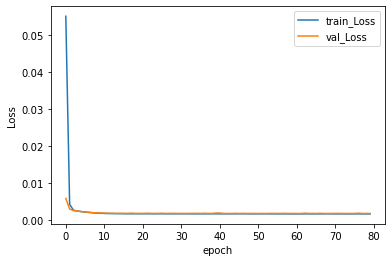

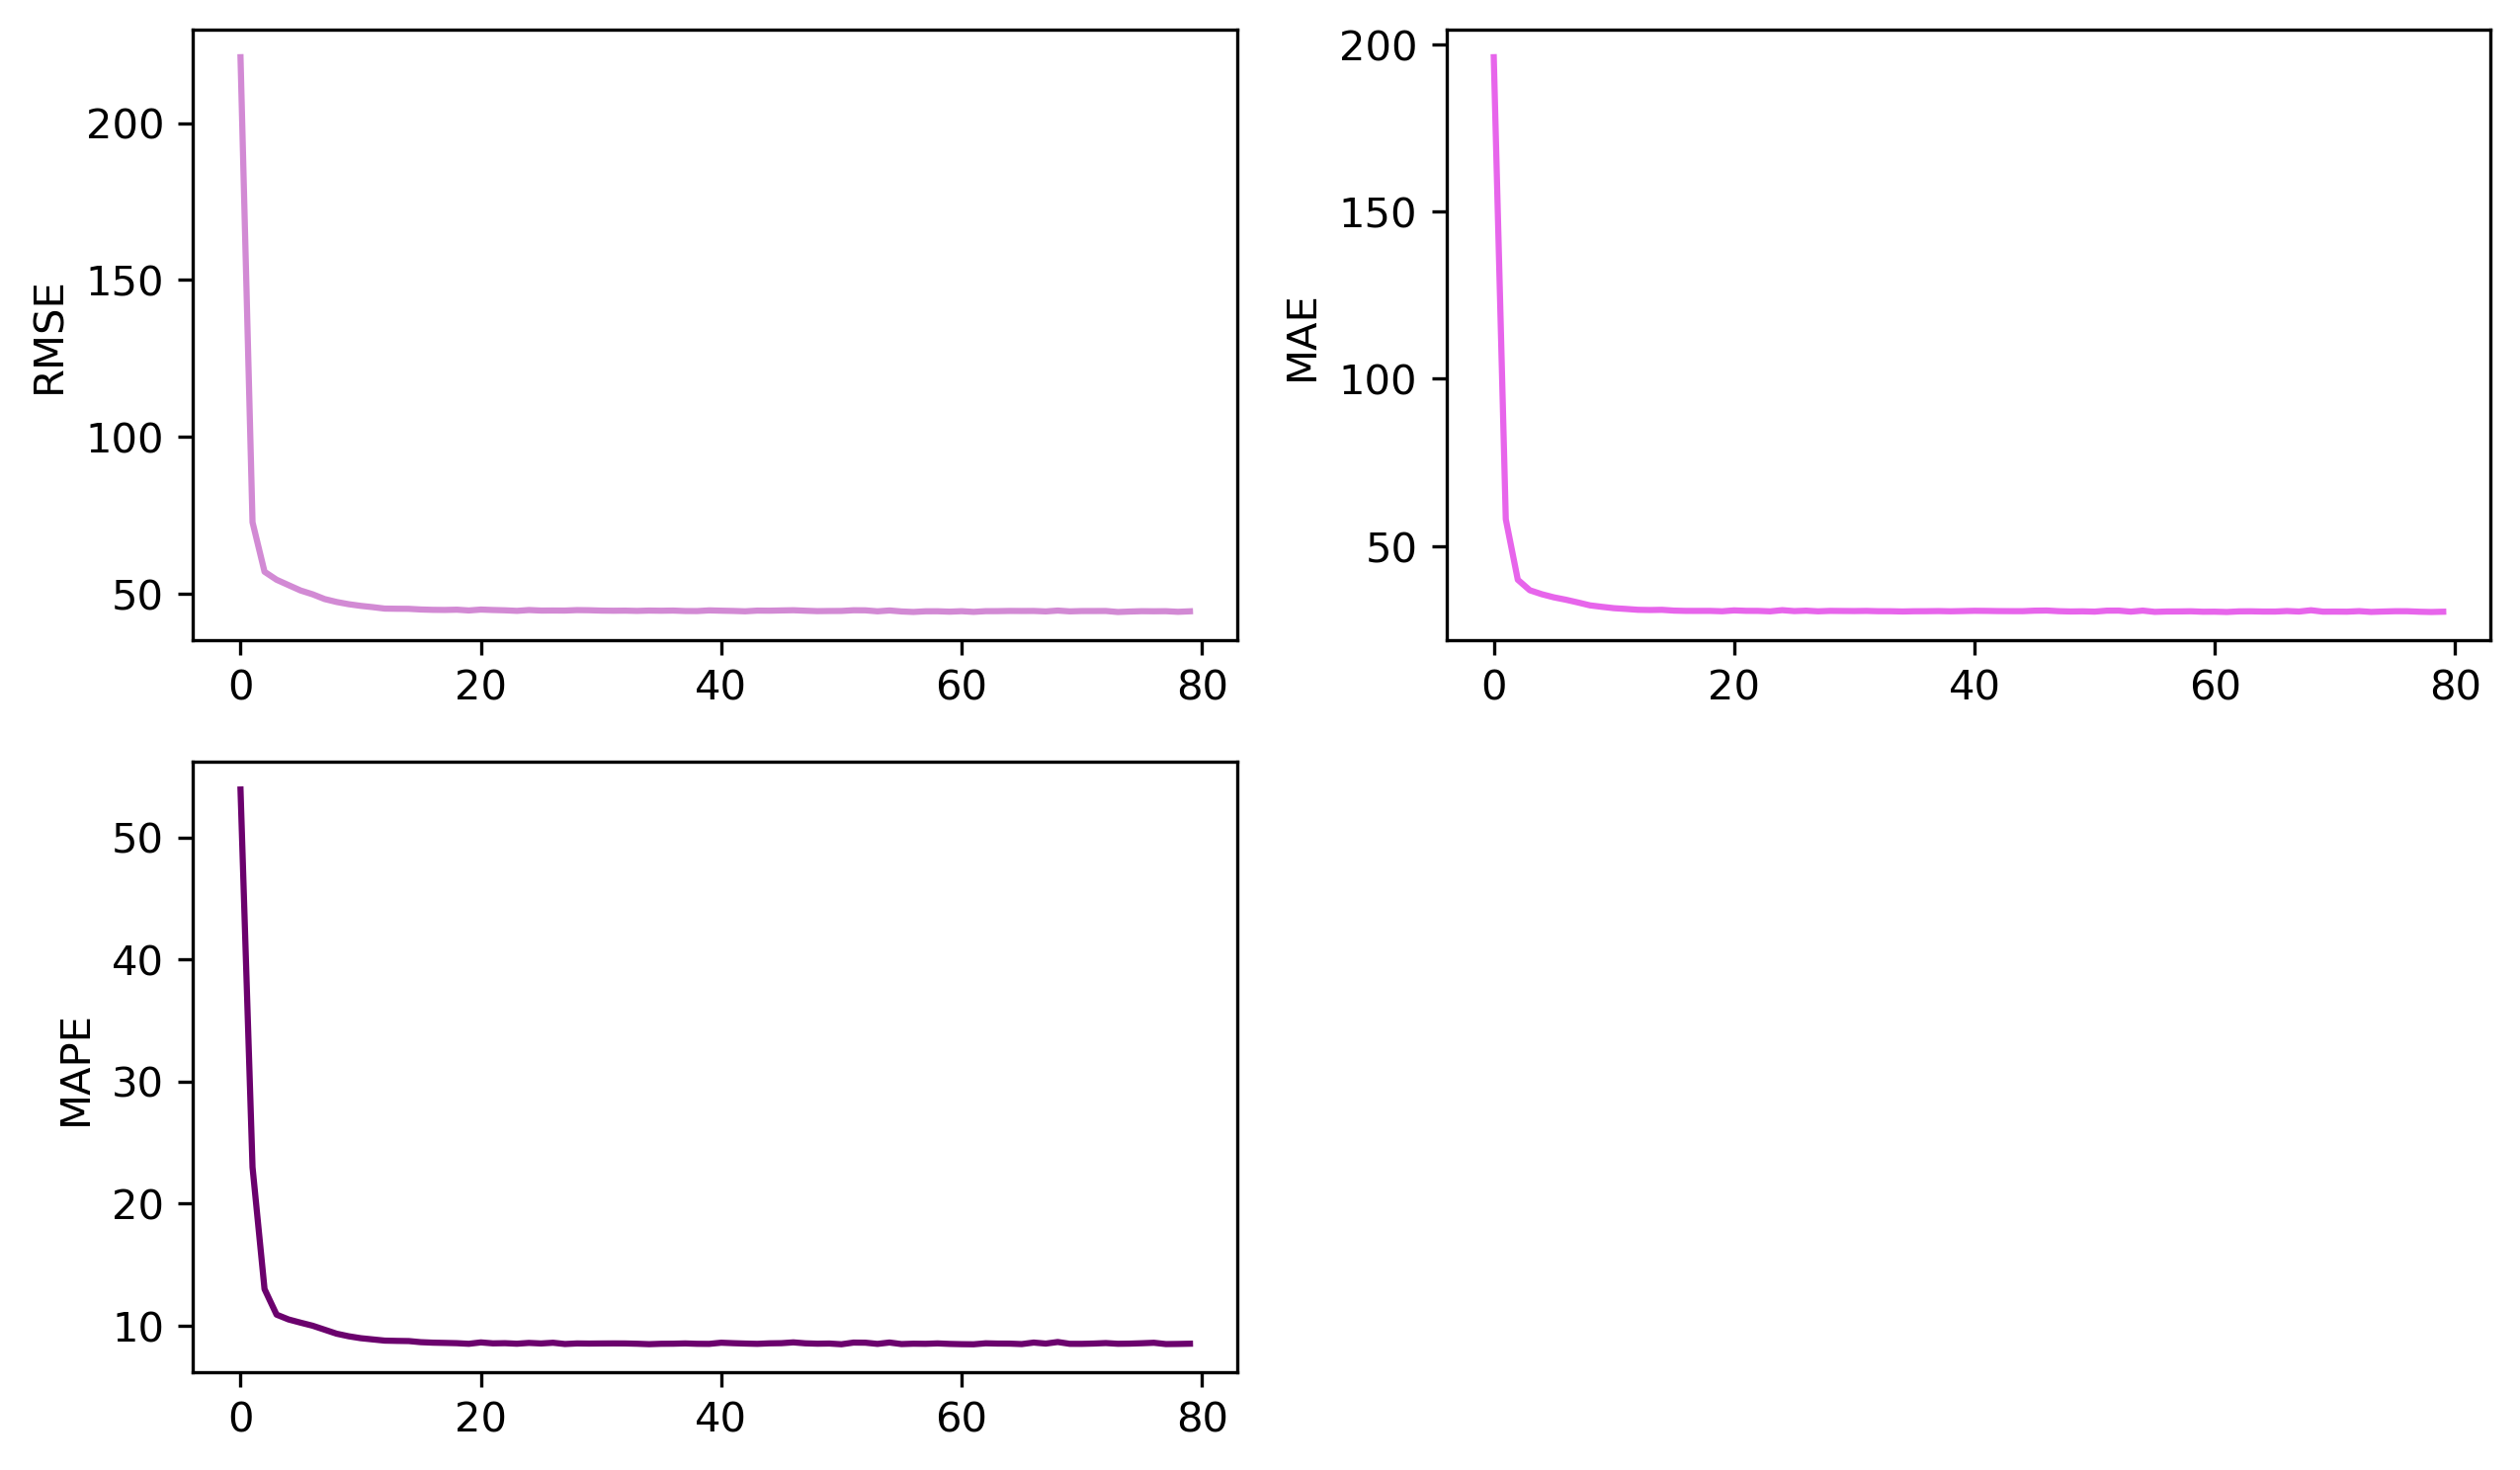

In [71]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## PyTorch接口实现GRU

In [75]:
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader, loss_func, TrafficData.denormalize, optimizer, epochs, early_stop=20, device=device, output_model=out_linear)

*** epoch1, train loss 0.0516, train rmse 246.6355, val loss 0.0162, val rmse 133.838594, time use 1.101s
*** epoch2, train loss 0.0151, train rmse 140.5823, val loss 0.0114, val rmse 111.571286, time use 0.759s
*** epoch3, train loss 0.0087, train rmse 105.8380, val loss 0.0048, val rmse 72.349888, time use 0.697s
*** epoch4, train loss 0.0032, train rmse 63.8188, val loss 0.0027, val rmse 50.637819, time use 0.730s
*** epoch5, train loss 0.0026, train rmse 57.4575, val loss 0.0026, val rmse 49.448950, time use 0.826s
*** epoch6, train loss 0.0025, train rmse 56.5406, val loss 0.0025, val rmse 48.357141, time use 0.773s
*** epoch7, train loss 0.0024, train rmse 55.4000, val loss 0.0025, val rmse 47.511510, time use 0.786s
*** epoch8, train loss 0.0023, train rmse 54.3545, val loss 0.0024, val rmse 46.522575, time use 0.714s
*** epoch9, train loss 0.0023, train rmse 53.4390, val loss 0.0023, val rmse 45.917603, time use 0.693s
*** epoch10, train loss 0.0022, train rmse 52.7035, val los

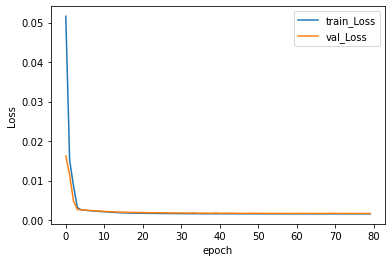

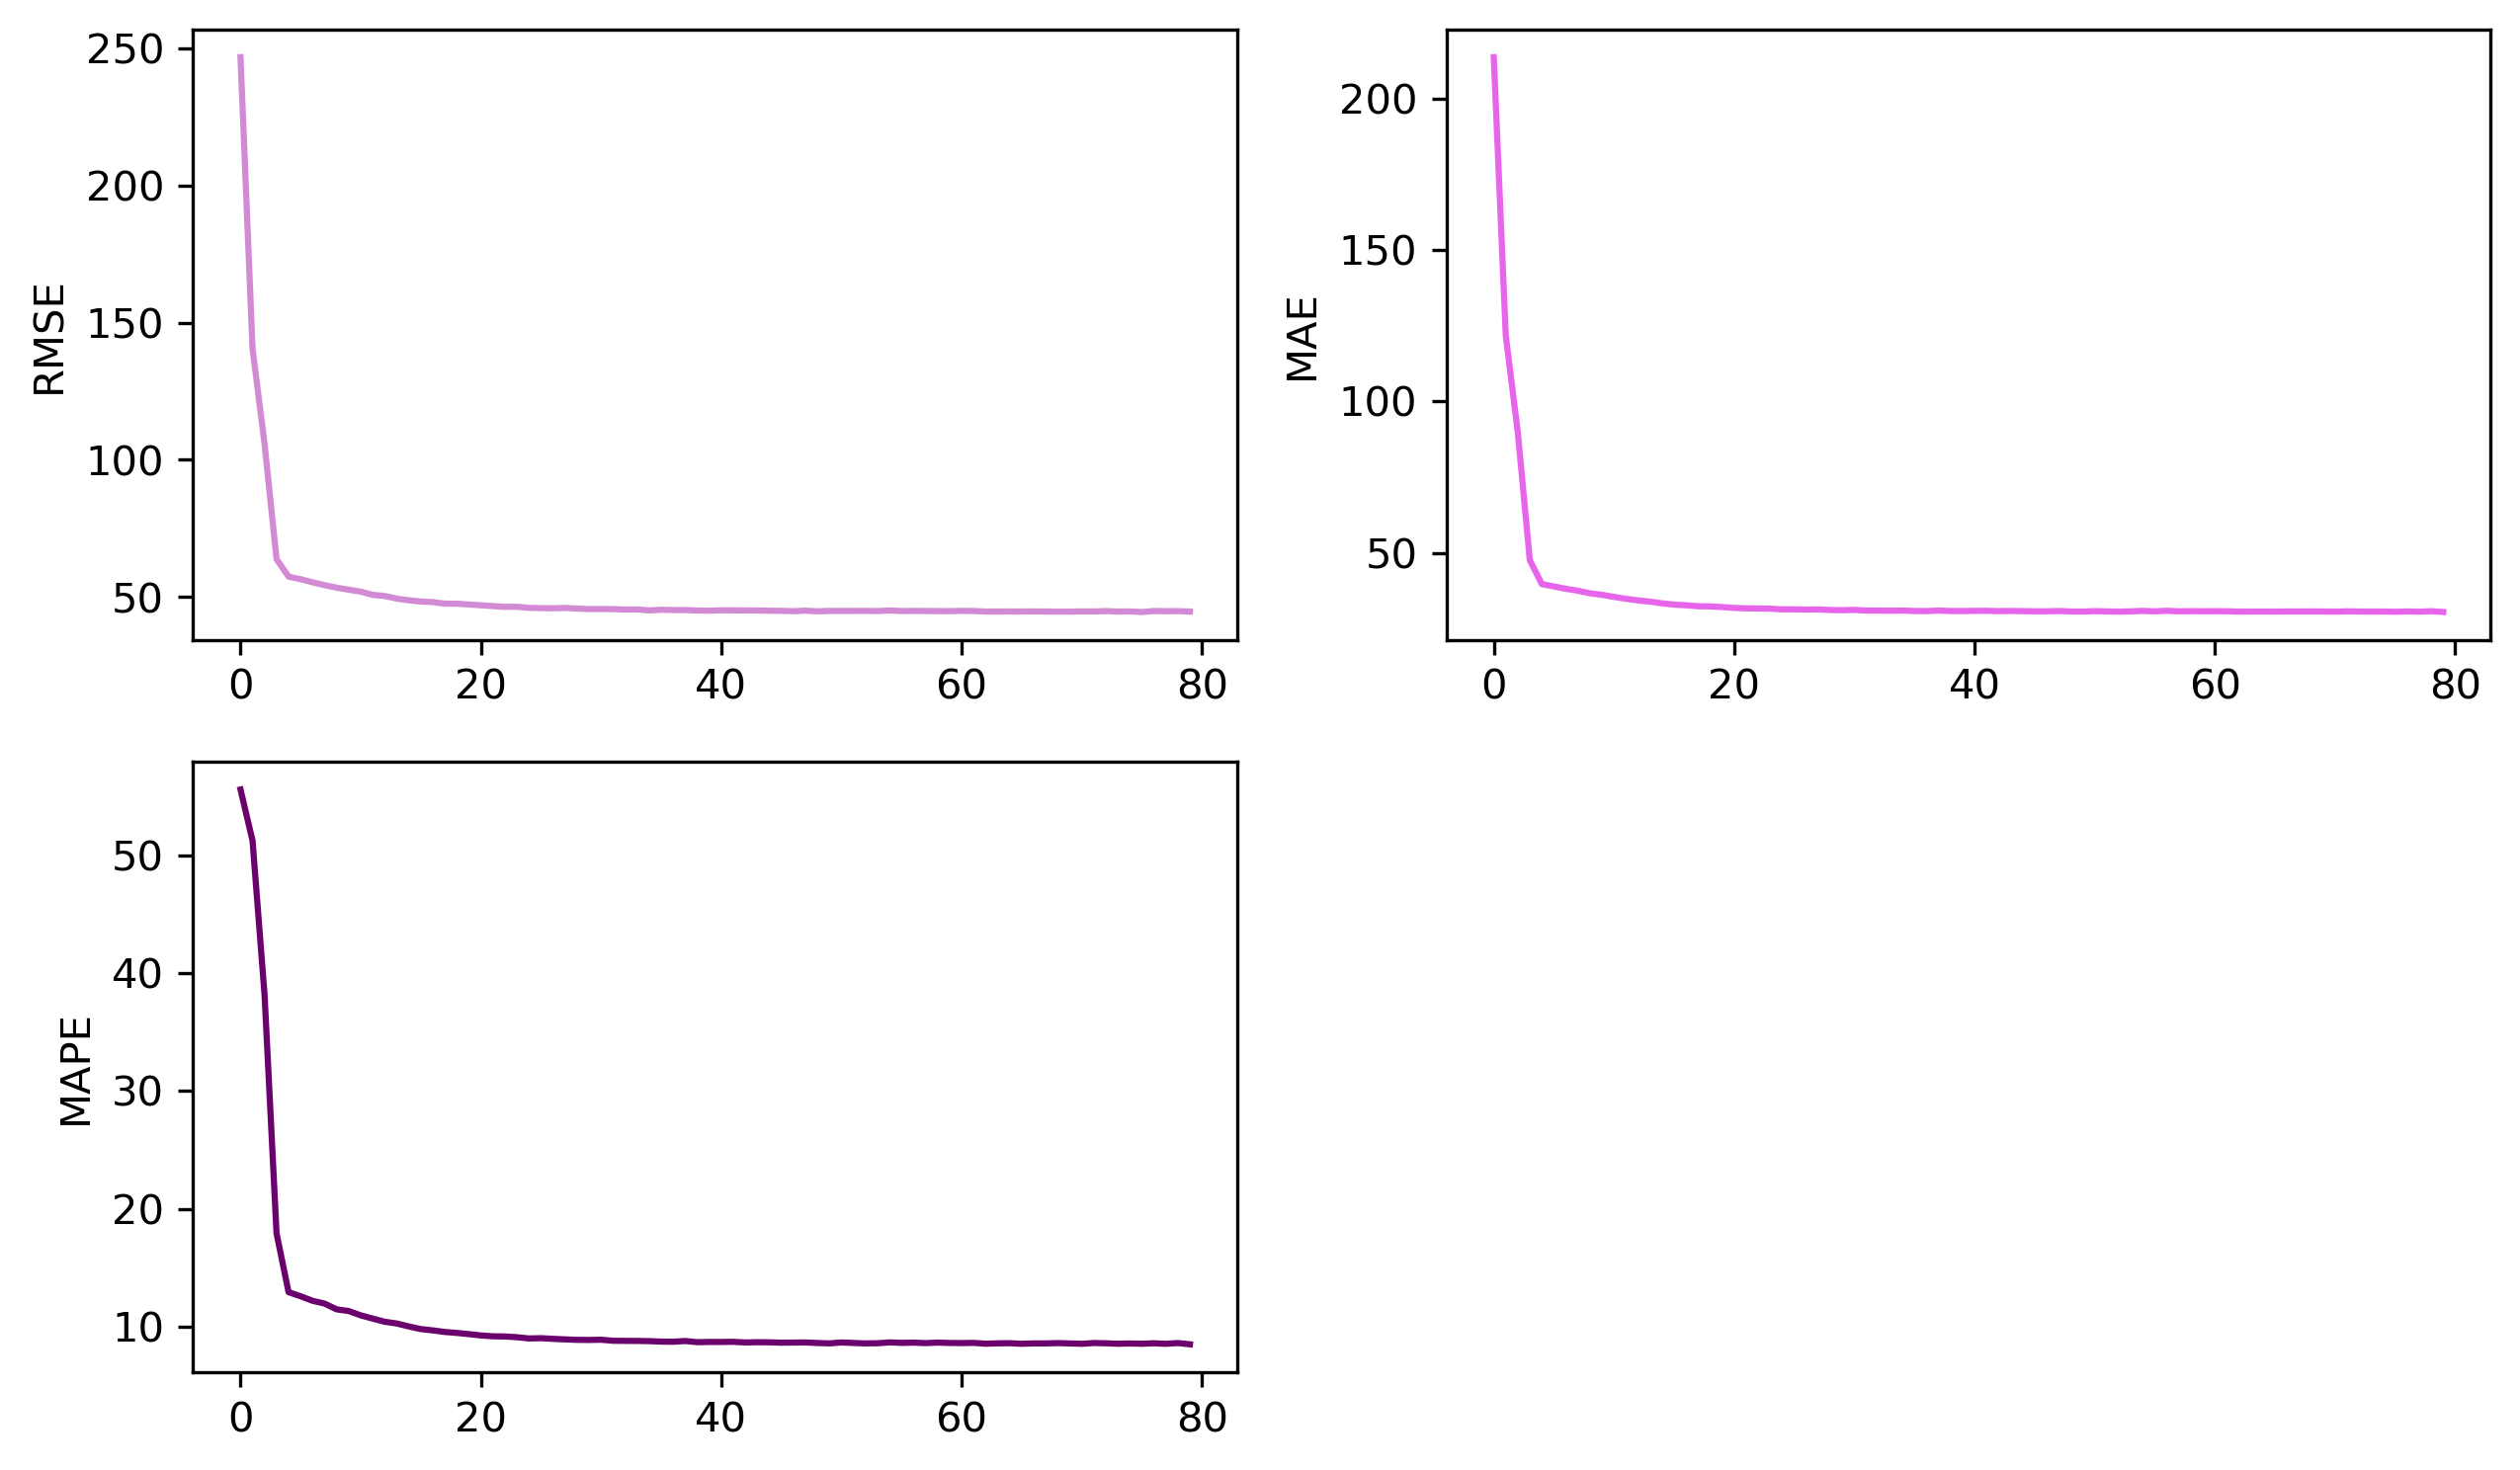

In [76]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

# 试验结果及对比

> 试验选取训练时间、预测精度、loss变化等指标对比调用pytorch接口实现的RNN、LSTM、GRU在车流数据集上的实验结果。其他变量固定如下：
- input_size = train_set.X.shape[-1]
- hidden_size = 64
- output_size = 1
- seq_len = 12
- lr = 0.0001
- epochs = 80
- loss_func = nn.MSELoss()

In [86]:
col = ["module", "train loss", "val loss", "total time", "test rmse", "test mae", "test mape"]
data = [
    ["my_rnn", 0.0016, 0.0017, 125.97,  36.003548, 25.233035, 7.62306],
    ["nn_rnn", 0.0016, 0.0017, 52.61, 36.220304, 25.490275, 8.136343],
    ["my_lstm", 0.0016, 0.0017, 353.29, 35.668198, 24.935084, 7.5897071],
    ["nn_lstm", 0.0016, 0.0017, 66.34, 36.1371643, 25.2727822, 7.8681708],
    ["my_gru", 0.0016, 0.0017, 360.59, 35.474596, 24.615480, 7.5132849],
    ["nn_gru", 0.0016, 0.0017, 56.62, 35.809445, 25.023667, 7.622266]
]
table_pd = pd.DataFrame(data=data, columns=col)

In [87]:
table_pd

,module,train loss,val loss,total time,test rmse,test mae,test mape
0,my_rnn,0.0016,0.0017,125.97,36.003548,25.233035,7.623060
1,nn_rnn,0.0016,0.0017,52.61,36.220304,25.490275,8.136343
2,my_lstm,0.0016,0.0017,353.29,35.668198,24.935084,7.589707
3,nn_lstm,0.0016,0.0017,66.34,36.137164,25.272782,7.868171
4,my_gru,0.0016,0.0017,360.59,35.474596,24.615480,7.513285
5,nn_gru,0.0016,0.0017,56.62,35.809445,25.023667,7.622266


> 结果分析：
1. 可以看出在时间上，手动实现的模型和调用接口的时间差距很大，这是正常的。但是手动实现的GRU时间长于LSTM，这和模型复杂度是相悖的。但是比对其他结果，可知模型运算结果是正确的，故分析为内部实现问题。初步分析发现，LSTM的并行化更高，这可能是LSTM时间较短的原因。调用结果的结果符合预期。
2. loss方面所有模型结果都是一样的。说明最后都收敛到的位置比较接近。
3. 预测精度方面，发现手动实现的模型比同类调用接口的模型，数值上会好一点，在0.1分度上体现，不是很明显。不同模型之间结果接近，相对而言是GRU更胜一筹，后边是LSTM和RNN。可以看到，在相对简单的数据集参数量更少的GRU效果会更好。

# 不同超参数对比分析

考虑到实验耗时问题，模型采用调包实现的RNN


## 不同学习率对比

In [88]:
# lr 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)



train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0044, train rmse 72.4163, val loss 0.0028, val rmse 48.544844, time use 1.801s
*** epoch2, train loss 0.0022, train rmse 53.1054, val loss 0.0024, val rmse 43.842729, time use 1.522s
*** epoch3, train loss 0.0020, train rmse 49.7893, val loss 0.0022, val rmse 42.161894, time use 1.488s
*** epoch4, train loss 0.0019, train rmse 48.5131, val loss 0.0020, val rmse 40.938735, time use 1.481s
*** epoch5, train loss 0.0018, train rmse 47.3791, val loss 0.0019, val rmse 39.583296, time use 1.557s
*** epoch6, train loss 0.0017, train rmse 46.6260, val loss 0.0019, val rmse 40.176148, time use 1.588s
*** epoch7, train loss 0.0017, train rmse 46.3861, val loss 0.0018, val rmse 38.479268, time use 1.580s
*** epoch8, train loss 0.0017, train rmse 45.7932, val loss 0.0018, val rmse 38.608968, time use 1.395s
*** epoch9, train loss 0.0016, train rmse 45.4492, val loss 0.0018, val rmse 37.934209, time use 1.579s
*** epoch10, train loss 0.0016, train rmse 45.4130, val loss 0.0

In [ ]:
result_e4 = [train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch]

In [90]:
# lr = 1e-3
lr = 0.001
epochs = 50
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)
result_e3 = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0016, train rmse 45.4354, val loss 0.0018, val rmse 39.180620, time use 1.853s
*** epoch6, train loss 0.0016, train rmse 45.1100, val loss 0.0017, val rmse 37.322735, time use 1.582s
*** epoch7, train loss 0.0016, train rmse 45.3190, val loss 0.0018, val rmse 38.436573, time use 1.535s
*** epoch8, train loss 0.0016, train rmse 45.4500, val loss 0.0017, val rmse 37.026072, time use 1.561s
*** epoch9, train loss 0.0016, train rmse 45.0153, val loss 0.0019, val rmse 40.355856, time use 1.519s
*** epoch10, train loss 0.0016, train rmse 45.3985, val loss 0.0017, val rmse 36.971326, time use 1.644s
*** epoch11, train loss 0.0016, train rmse 44.6420, val loss 0.0017, val rmse 36.977979, time use 1.503s
*** epoch12, train loss 0.0016, train rmse 44.9320, val loss 0.0017, val rmse 36.791875, time use 1.541s
*** epoch13, train loss 0.0016, train rmse 44.7638, val loss 0.0017, val rmse 36.935759, time use 1.664s
*** epoch14, train loss 0.0016, train rmse 44.9431, val loss

In [91]:
# lr = 1e-2
lr = 0.01
epochs = 50
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)
result_e2 = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0279, train rmse 130.5567, val loss 0.0023, val rmse 47.337880, time use 2.020s
*** epoch2, train loss 0.0022, train rmse 52.4481, val loss 0.0019, val rmse 40.351386, time use 2.368s
*** epoch3, train loss 0.0018, train rmse 47.3967, val loss 0.0021, val rmse 44.813013, time use 2.189s
*** epoch4, train loss 0.0017, train rmse 46.1990, val loss 0.0017, val rmse 37.123998, time use 3.160s
*** epoch5, train loss 0.0017, train rmse 46.2710, val loss 0.0017, val rmse 37.991326, time use 2.345s
*** epoch6, train loss 0.0016, train rmse 45.5762, val loss 0.0017, val rmse 38.065639, time use 2.040s
*** epoch7, train loss 0.0017, train rmse 46.0413, val loss 0.0017, val rmse 36.946125, time use 2.026s
*** epoch8, train loss 0.0017, train rmse 45.7994, val loss 0.0017, val rmse 36.991877, time use 2.105s
*** epoch9, train loss 0.0016, train rmse 45.5916, val loss 0.0019, val rmse 40.654723, time use 2.190s
*** epoch10, train loss 0.0017, train rmse 46.5032, val loss 0.

> lr对比结果分析
    通过1e-2、 1e-3、 1e-4三个不同数量级的学习率进行对比实验，我们可以看出，学习率越高收敛速度明显变快，同时模型最终的预测效果比较接近，就数值而言是1e-3最好。同时，学习率的提高减少了实验耗时，1e-2时，实验在27轮早停。

## 不同隐藏神经元数对比

In [94]:
# hidden_size 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)



result_hidden64= train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch21, train loss 0.0016, train rmse 45.5220, val loss 0.0017, val rmse 37.596598, time use 2.151s
*** epoch22, train loss 0.0016, train rmse 45.0479, val loss 0.0017, val rmse 37.274938, time use 1.627s
*** epoch23, train loss 0.0016, train rmse 45.2774, val loss 0.0017, val rmse 38.193037, time use 1.983s
*** epoch24, train loss 0.0016, train rmse 45.5215, val loss 0.0017, val rmse 37.045029, time use 1.357s
*** epoch25, train loss 0.0016, train rmse 45.4484, val loss 0.0017, val rmse 37.556950, time use 1.667s
*** epoch26, train loss 0.0016, train rmse 45.2939, val loss 0.0017, val rmse 37.375902, time use 1.501s
*** epoch27, train loss 0.0016, train rmse 45.2116, val loss 0.0017, val rmse 36.771489, time use 1.564s
*** epoch28, train loss 0.0016, train rmse 45.1344, val loss 0.0017, val rmse 36.915194, time use 1.608s
*** epoch29, train loss 0.0016, train rmse 45.1301, val loss 0.0018, val rmse 39.147967, time use 1.497s
*** epoch30, train loss 0.0016, train rmse 45.3953, val

In [95]:
# hidden size = 128
hidden_size = 128
loss_func = nn.MSELoss()
my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

result_hidden128= train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0038, train rmse 60.0194, val loss 0.0021, val rmse 43.294106, time use 1.645s
*** epoch2, train loss 0.0018, train rmse 48.3299, val loss 0.0018, val rmse 38.623029, time use 1.720s
*** epoch3, train loss 0.0017, train rmse 46.3219, val loss 0.0017, val rmse 37.849620, time use 1.722s
*** epoch4, train loss 0.0017, train rmse 45.7234, val loss 0.0017, val rmse 37.257166, time use 1.796s
*** epoch5, train loss 0.0017, train rmse 45.7439, val loss 0.0018, val rmse 38.468519, time use 1.695s
*** epoch6, train loss 0.0017, train rmse 45.9348, val loss 0.0017, val rmse 37.505742, time use 1.758s
*** epoch7, train loss 0.0016, train rmse 45.4370, val loss 0.0019, val rmse 40.481774, time use 1.761s
*** epoch8, train loss 0.0017, train rmse 45.7835, val loss 0.0019, val rmse 40.890592, time use 2.428s
*** epoch9, train loss 0.0016, train rmse 45.4745, val loss 0.0017, val rmse 38.817216, time use 2.238s
*** epoch10, train loss 0.0016, train rmse 45.6842, val loss 0.0

In [96]:
# hidden size = 32
hidden_size = 32
loss_func = nn.MSELoss()
my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

result_hidden32= train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.0042, train rmse 69.1001, val loss 0.0025, val rmse 45.713972, time use 2.226s
*** epoch2, train loss 0.0020, train rmse 50.1468, val loss 0.0020, val rmse 41.012304, time use 2.246s
*** epoch3, train loss 0.0017, train rmse 46.9268, val loss 0.0019, val rmse 40.220387, time use 2.369s
*** epoch4, train loss 0.0017, train rmse 45.8681, val loss 0.0019, val rmse 40.701664, time use 2.261s
*** epoch5, train loss 0.0016, train rmse 45.3185, val loss 0.0017, val rmse 37.262455, time use 2.124s
*** epoch6, train loss 0.0016, train rmse 45.4295, val loss 0.0017, val rmse 37.785041, time use 1.873s
*** epoch7, train loss 0.0016, train rmse 45.3934, val loss 0.0017, val rmse 37.420238, time use 1.814s
*** epoch8, train loss 0.0016, train rmse 45.5532, val loss 0.0018, val rmse 38.050207, time use 1.709s
*** epoch9, train loss 0.0016, train rmse 45.3968, val loss 0.0018, val rmse 39.123991, time use 1.791s
*** epoch10, train loss 0.0017, train rmse 45.7504, val loss 0.0

由batch size 32 64 128进行实验
对比实验结果可以发现，效果而言，数值很接近，相差不明显。明显的是，更大的batch size模型收敛速度更快，得到最佳模型的轮数更早，更早早停。所以选择一个合适的batch size对于训练速度有比较大的影响。

# 实验心得

1. 这次的实验和以往不同，课程组给出了许多现成的代码模块可以调用，这让我可以专注于实验核心的同时，也有机会可以学习借鉴他人的代码，这对自己的编码能力和综合学习有很大的帮助。
2. 一开始的时候，手动实现的模型总是爆参数位置在cpu和cuda不同的两个地方。当时还比较纳闷，模型已经显式调用传递到cuda上了，怎么还会有这样的问题呢——原来是在并行计算的时候，没有把合并后的参数指定为Parameter。调用 $ net.to(device)$ 时，模型只会吧Parameter的参数移到cuda上。
3. 其他的收获还有很多，包括自定义类的组织和时间序列数据的预处理。在这样的过程中，对python和pytorch的语法有更深入的理解。